# Gaussian Process error

## N-point Green's functions

In [1]:
import numpy as np

from qutip import *
from qutip.qip.operations import rx
from pylab import *

import functools

In [260]:
def greens_plot(num_points, meas, corr_vec):
    f, a = plt.subplots(1, len(meas), sharex=True, sharey=True, figsize=(8 * len(meas), 6))
    for idx, (k, _) in enumerate(meas.items()):
        corr_vec = corr_vec_d[k]
        for corr in corr_vec:
            a[idx].plot(tlist, np.real(corr), alpha=0.5)
        a[idx].plot(tlist, np.mean(np.real(corr_vec), axis=0), 'r+', label='mean')

        a[idx].set_xlabel(r'$\tau$')
        a[idx].set_ylabel(fr'{num_points}-point correlation')

        title = fr'Correlation $\left<{k}(t + \tau), {k}(t)\right>$' if num_points == 2 else fr'Correlation $\left<{k}(t), {k}(t + \tau), {k}(t)\right>$'
        a[idx].set_title(title)

    f.legend()
    f.show()

In [6]:
# Classical stochastic parameterization of sigmax() rotation.
def gaussian_process(prev, i, mu, sigma, T):
    if i > T:
        return prev
    i += 1
    prev.append(np.random.normal(mu, sigma) * sigmax())
    return gaussian_process(prev, i, mu, sigma, T)


# Cached.
def hamiltonian(gp, t, *args):
    # t is rounded since we're working on the lattice.
    t = int(t)
    return gp[t]


# Prepare in sigmaz().
state0 = basis(2, 0)
# Hermitian observables.
meas = {
    r'\sigma_X': sigmax(),
    r'\sigma_Y': sigmay(),  # optimal
    r'\sigma_Z': sigmaz(),
    # r'\frac{1}{\sqrt{2}}(\sigma_X + \sigma_Y)': (sigmax() + sigmay() ) / np.sqrt(2),
}

# Number of independent GP chains to sample.
M = 100
# Lattice size (temporal)
T = 10
# Maximum temporal radius on lattice to compute two-point correlations.
TAU_MAX = 10
tlist = np.linspace(0, TAU_MAX - 1, TAU_MAX, dtype=np.int)

In [271]:
MU = 0
SIGMA = np.pi / 18

NUM_POINTS = 2
assert NUM_POINTS == 2 or NUM_POINTS == 3, "Green's must be 2- of 3-point."

expected_random_2sd_distance = np.sqrt(2 * SIGMA * 2 * T / np.pi)
assert expected_random_2sd_distance < np.pi/2, f"Random walk distance should remain bounded to hemisphere: expected {expected_random_2sd_distance} < {np.pi/2}"


def get_greens(m, num_points=2):
    corr_vec = []
    for i in range(M):
        # Sample GP.
        gp = gaussian_process([qeye(2)], 0, MU, SIGMA, 2 * T)
        h = functools.partial(hamiltonian, gp)
        greens = correlation_2op_1t if num_points == 2 else functools.partial(correlation_3op_1t, c_op=m)
        # Compute two-points.
        corr_vec.append(
            greens(H=h, state0=state0, taulist=tlist, c_ops=[Qobj([[0.0, 0.0],[0.0, 0.0]])], a_op=m, b_op=m)
        )
    return corr_vec


corr_vec_d = {}
for k, v in meas.items():
    corr_vec_d[k] = get_greens(v, num_points=NUM_POINTS)

In [306]:
theta = np.pi / 5

green_2 = lambda sigmai: rx(theta) * sigmai * rx(theta).dag() * sigmai * state0 * state0.dag()
green_3 = lambda sigmai: sigmai * green_2(sigmai)

print(green_2(sigmaz()).tr(), "\n")
print(green_2(sigmay()).tr(), "\n")

# Commutes with prepared state.
print(green_3(sigmaz()), "\n")
print((green_3(sigmaz())).tr(), "\n")
# Does not commute. Hence, distinction becomes apparent at 3-point.
print(green_3(sigmay()), "\n")
print((green_3(sigmay())).tr(), "\n")

0.8090169943749473 

0.8090169943749473 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.80901699+0.j         0.        +0.j        ]
 [0.        +0.58778525j 0.        +0.j        ]] 

0.8090169943749473 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.58778525+0.j          0.        +0.j        ]
 [ 0.        +0.80901699j  0.        +0.j        ]] 

-0.587785252292473 



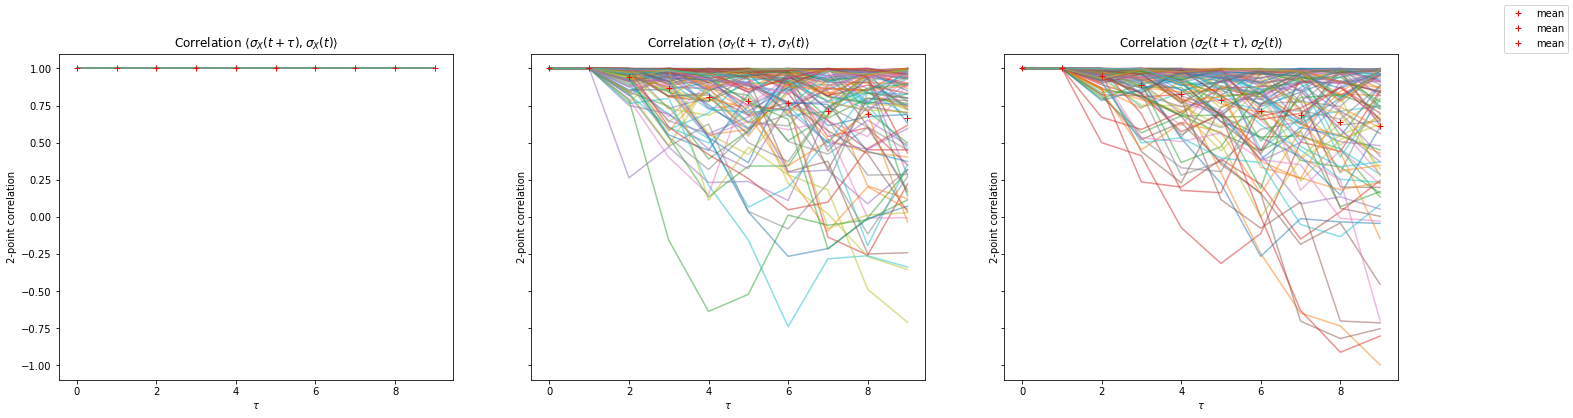

In [272]:
greens_plot(NUM_POINTS, meas, corr_vec)

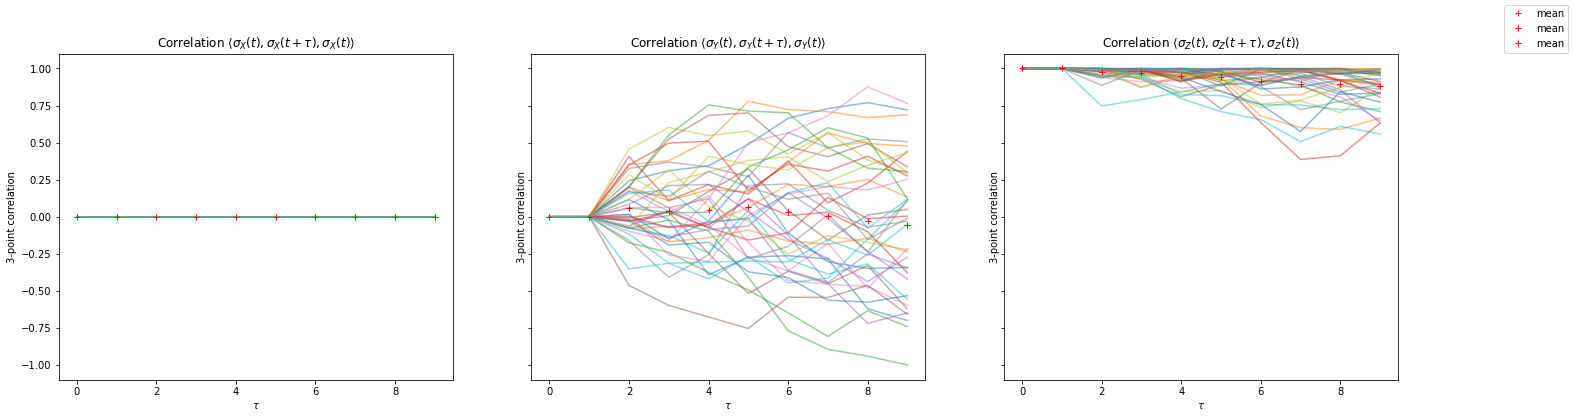

In [256]:
greens_plot(NUM_POINTS, meas, corr_vec)

## Keldysh

In [193]:
import keldysh_sim as kd
import keldysh_utils as kd_utils

import numpy as np
import altair as alt
import pandas as pd

from qutip import *

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  del sys.path[0]


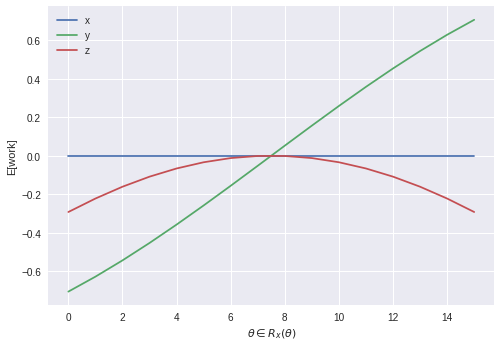

In [79]:
from matplotlib import pyplot as plt

thetas = np.linspace(-np.pi/4, np.pi/4, 16)
state0 = basis(2, 0)

# This function is special. We couldn't find this closed form without KQPD because |0><0| does not commute with sigmay()

trs = {
    'x': (sigmax(), []),
    'y': (sigmay(), []),
    'z': (sigmaz(), [])
}
for s in trs:
    for theta in thetas:
        w = (rx(theta) * trs[s][0] * rx(theta).dag() - trs[s][0])
        trs[s][1].append((w * (state0) * state0.dag()).tr())
    
for s in trs:
    plt.plot(trs[s][1], label=s)

plt.ylabel("E[work]")
plt.xlabel(r"$\theta \in R_x(\theta)$")
plt.legend()
plt.show()


In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
# Temporal lattice size.
T = 2
# Number of independent GP chains to sample.
M = 1000
SIGMA = np.pi / 8
MU = 0

# sqrt(2SD * 2 * lattice_length / np.pi)
expected_random_2sd_distance = np.sqrt(2 * SIGMA * 2 * (2 * T) / np.pi)
print(f"Root-mean-square deviation: {expected_random_2sd_distance}")
# assert expected_random_2sd_distance < np.pi/2, f"Random walk distance should remain bounded to hemisphere: expected {expected_random_2sd_distance} < {np.pi/2}"
# Prepare in sigmaz().
state0 = np.array(basis(2, 0))
print(f"Prepared state: {state0}")

def get_eig(sigma_i):
    return np.array([np.array(e) for e in sigma_i.eigenstates()[1]])


np_sx = np.array(sigmax())
np_sy = np.array(sigmay())
np_sz = np.array(sigmaz())
np_syz = np.array((sigmay() + sigmaz()) / np.sqrt(2))
np_sxz = np.array((sigmax() + sigmaz()) / np.sqrt(2))

# Hermitian observables.
meas = {
    r'\sigma_X\rightarrow\sigma_X': ([np_sx], [get_eig(sigmax())]),
    r'\sigma_Y\rightarrow\sigma_Y': ([np_sy], [get_eig(sigmay())]),
    r'\sigma_Z\rightarrow\sigma_Z': ([np_sz], [get_eig(sigmaz())]),
    r'\frac{1}{\sqrt{2}}(\sigma_Y + \sigma_Z)\rightarrow\frac{1}{\sqrt{2}}(\sigma_Y + \sigma_Z)': ([np_syz], [get_eig((sigmay() + sigmaz()) / np.sqrt(2))]),
    r'\sigma_Y\rightarrow\sigma_Z': ([np_sy, np_sz], [get_eig(sigmay()), get_eig(sigmaz())]),  # optimal
    r'\sigma_Z\rightarrow\sigma_Y': ([np_sz, np_sy], [get_eig(sigmaz()), get_eig(sigmay())]),  # optimal
}

meas_names = list(meas.keys())
meas_eigs = [v[1] for k, v in meas.items()]
keldysh_vec, keldysh_bdry_vec = kd.sample_gps(meas_names, meas_eigs, M, MU, SIGMA, T, state0)
# print(keldysh_vec)
keldysh_vec = kd_utils.qobj_to_numpy(keldysh_vec)
keldysh_bdry_vec = kd_utils.qobj_to_numpy(keldysh_bdry_vec)
# print(keldysh_vec)

Root-mean-square deviation: 1.4142135623730951
Prepared state: [[1.+0.j]
 [0.+0.j]]


In [214]:
kd_df = kd_utils.keldysh_vec_to_pd(keldysh_vec, T)

kd_df_mean = kd_df.groupby(['z', 'basis']).agg({'p(z)': ['mean']})

# kd_df_mean

In [215]:
# Check that quasi-probability distributions are indeed normalized.
kd_df_mean.groupby(['basis']).sum()

,p(z)
,mean
basis,
\frac{1}{\sqrt{2}}(\sigma_Y + \sigma_Z)\rightarrow\frac{1}{\sqrt{2}}(\sigma_Y + \sigma_Z),1.0
\sigma_X\rightarrow\sigma_X,1.0
\sigma_Y\rightarrow\sigma_Y,1.0
\sigma_Y\rightarrow\sigma_Z,1.0
\sigma_Z\rightarrow\sigma_Y,1.0
\sigma_Z\rightarrow\sigma_Z,1.0


In [216]:
kd_df_mean.groupby(['basis']).std()

,p(z)
,mean
basis,
\frac{1}{\sqrt{2}}(\sigma_Y + \sigma_Z)\rightarrow\frac{1}{\sqrt{2}}(\sigma_Y + \sigma_Z),0.308153
\sigma_X\rightarrow\sigma_X,0.273861
\sigma_Y\rightarrow\sigma_Y,0.219498
\sigma_Y\rightarrow\sigma_Z,0.334212
\sigma_Z\rightarrow\sigma_Y,0.273942
\sigma_Z\rightarrow\sigma_Z,0.376480


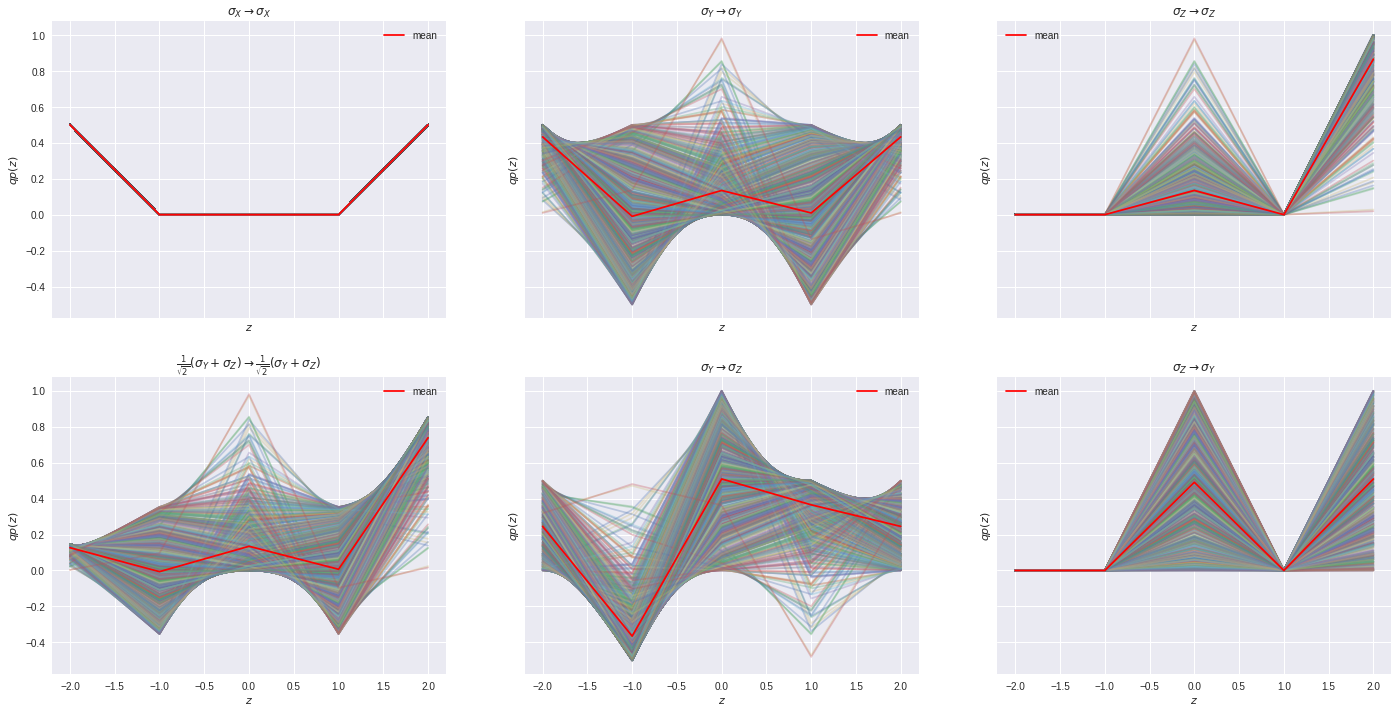

In [217]:
kd_utils.keldysh_plot(meas, keldysh_vec, T)

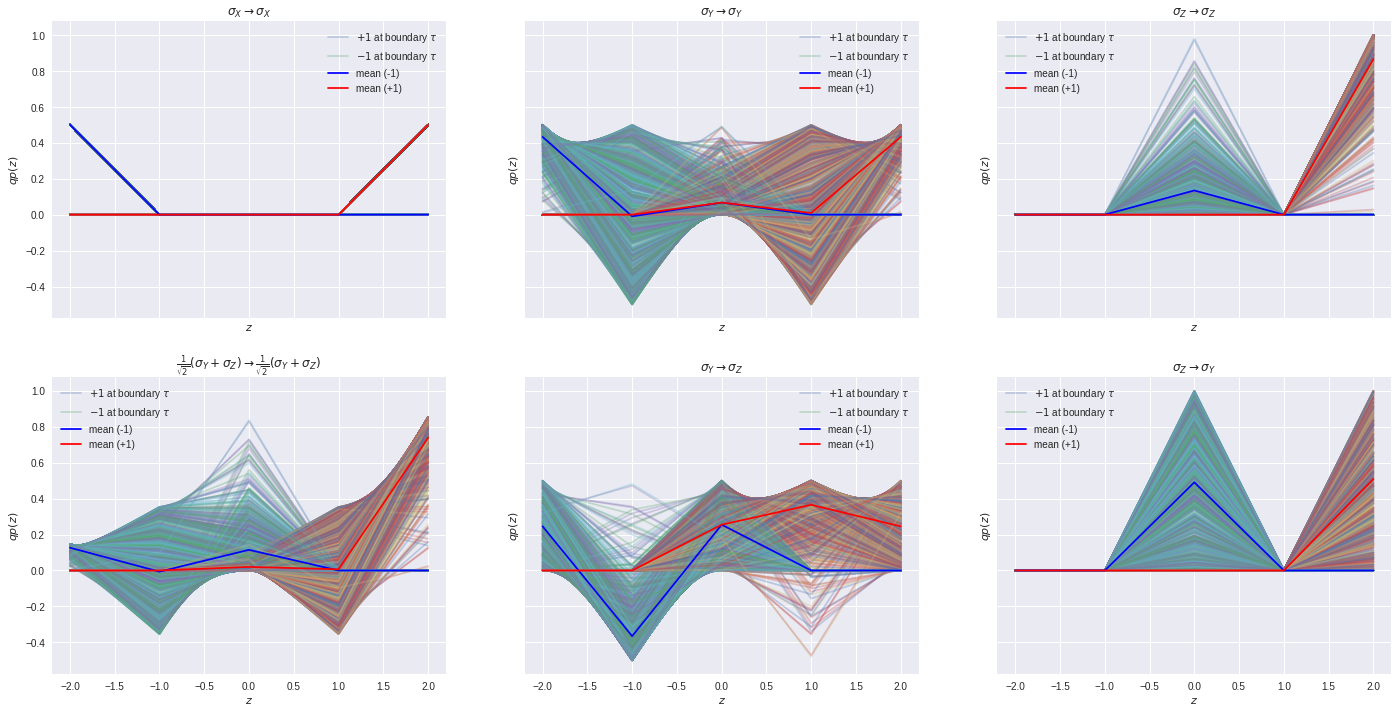

In [218]:
kd_utils.keldysh_bdry_plot(meas, keldysh_bdry_vec, T)

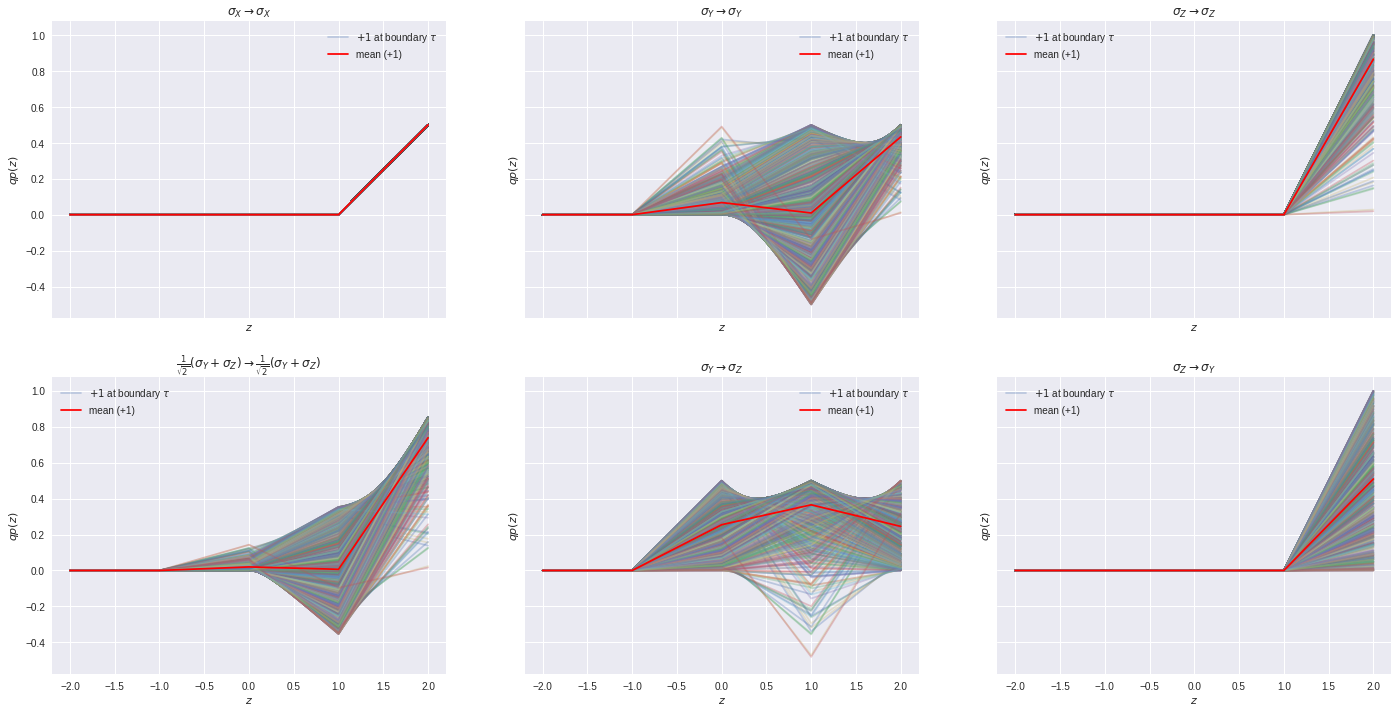

In [219]:
kd_utils.keldysh_bdry_plot(meas, keldysh_bdry_vec, T, eig=1)

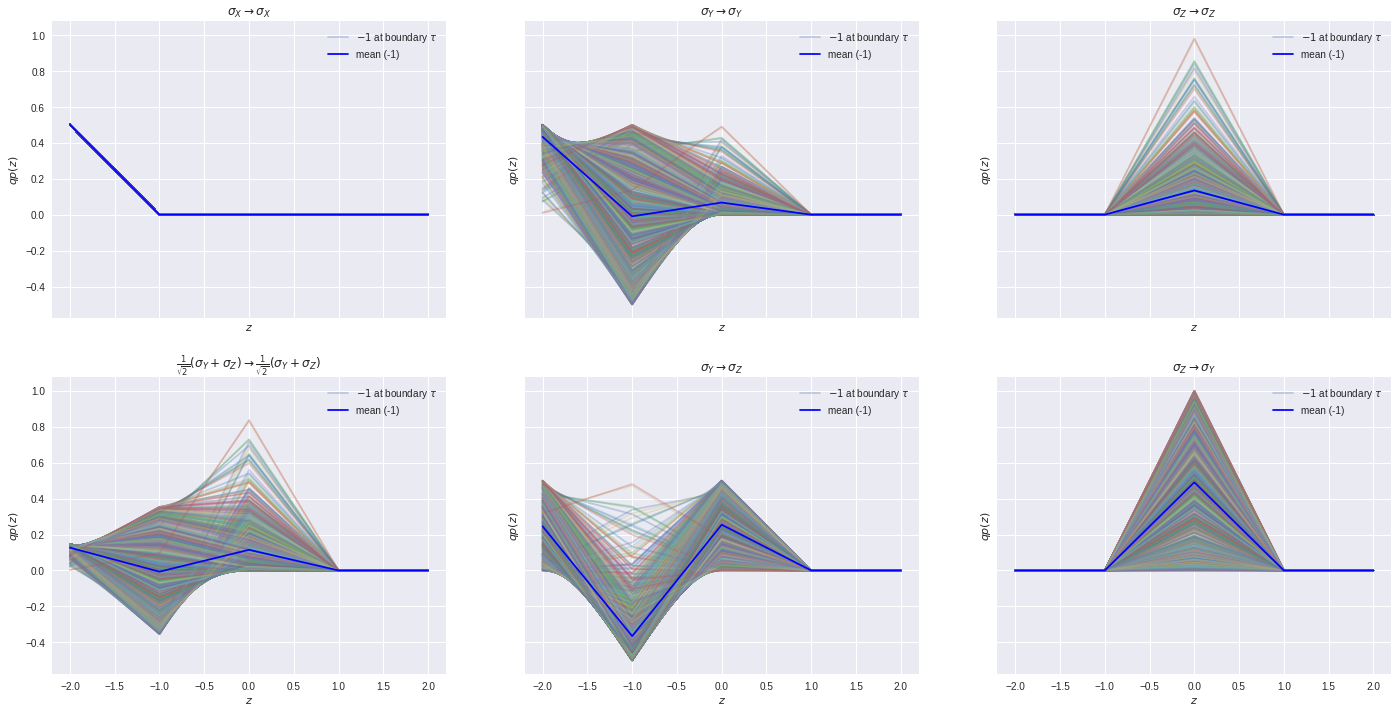

In [220]:
kd_utils.keldysh_bdry_plot(meas, keldysh_bdry_vec, T, eig=-1)

In [80]:
base = alt.Chart(kd_df).mark_line(opacity=0.5).encode(
    alt.X('z:Q'),
    alt.Y('p(z):Q'),
    alt.Column('basis:N'),
    alt.Color('random_gp:N', legend=None),
)

base

alt.Chart(...)